In [1]:
import pandas as pd

# 1. Baca file CSV
pzem_df = pd.read_csv("PZEM-017_all_renamed.csv")
weather_df = pd.read_csv("tren_cuaca_all_renamed.csv")

# 2. Konversi kolom waktu ke datetime
pzem_df['created_at'] = pd.to_datetime(pzem_df['created_at'])
weather_df['created_at'] = pd.to_datetime(weather_df['created_at'])

# 3. Set 'created_at' sebagai index
pzem_df.set_index('created_at', inplace=True)
weather_df.set_index('created_at', inplace=True)

# 4. Resample kedua dataset ke interval 2 menit
pzem_2min = pzem_df.resample('2T').mean()
weather_2min = weather_df.resample('2T').mean()

# 5. Gabungkan kedua dataset berdasarkan waktu (inner join agar sinkron)
combined_2min = pzem_2min.join(weather_2min, lsuffix='_pzem', rsuffix='_weather', how='inner')

# 6. Reset index jika ingin simpan kembali ke CSV
combined_2min.reset_index(inplace=True)

# 7. Simpan ke file jika diperlukan
combined_2min.to_csv("data_gabungan_2menit.csv", index=False)


C:\Users\marsh\AppData\Local\Temp\ipykernel_33852\695387216.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pzem_2min = pzem_df.resample('2T').mean()
C:\Users\marsh\AppData\Local\Temp\ipykernel_33852\695387216.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  weather_2min = weather_df.resample('2T').mean()


In [34]:
import pandas as pd

# Load both files
file_pzem = 'PZEM-017_all_renamed.csv'
file_tren_cuaca = 'tren_cuaca_all_renamed.csv'

pzem_data = pd.read_csv(file_pzem)
tren_cuaca_data = pd.read_csv(file_tren_cuaca)

# Convert 'created_at' columns to datetime format
pzem_data['created_at'] = pd.to_datetime(pzem_data['created_at'])
tren_cuaca_data['created_at'] = pd.to_datetime(tren_cuaca_data['created_at'])

# Extract the date part of 'created_at' to group by date
pzem_data['date'] = pzem_data['created_at'].dt.date
tren_cuaca_data['date'] = tren_cuaca_data['created_at'].dt.date

# Count the number of entries per date
pzem_daily_count = pzem_data.groupby('date').size()
tren_cuaca_daily_count = tren_cuaca_data.groupby('date').size()

# Find dates with more than 500 entries in both datasets
pzem_dates_above_500 = pzem_daily_count[pzem_daily_count > 500]
tren_cuaca_dates_above_500 = tren_cuaca_daily_count[tren_cuaca_daily_count > 500]

# Find the intersection of dates where both datasets have more than 500 entries
common_dates_above_500 = pzem_dates_above_500.index.intersection(tren_cuaca_dates_above_500.index)

# Output the common dates
print(common_dates_above_500)
print("Jumlah tanggal:", len(common_dates_above_500))


Index([2025-05-15, 2025-05-16, 2025-05-17, 2025-05-18, 2025-05-19, 2025-05-20,
       2025-05-21, 2025-05-22, 2025-05-23, 2025-06-19, 2025-06-20, 2025-06-21,
       2025-06-23, 2025-06-25, 2025-06-26, 2025-06-27, 2025-06-28, 2025-06-29,
       2025-06-30, 2025-07-01, 2025-07-02, 2025-07-03, 2025-07-04, 2025-07-05,
       2025-07-06, 2025-07-07],
      dtype='object', name='date')
Jumlah tanggal: 26


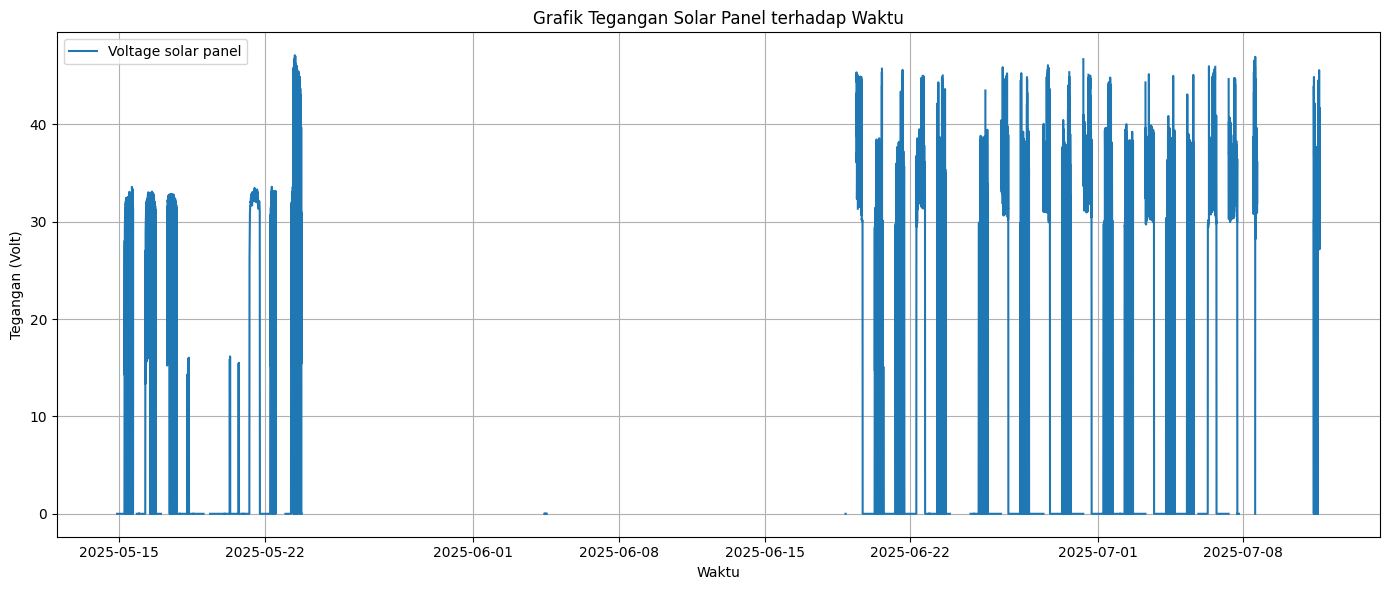

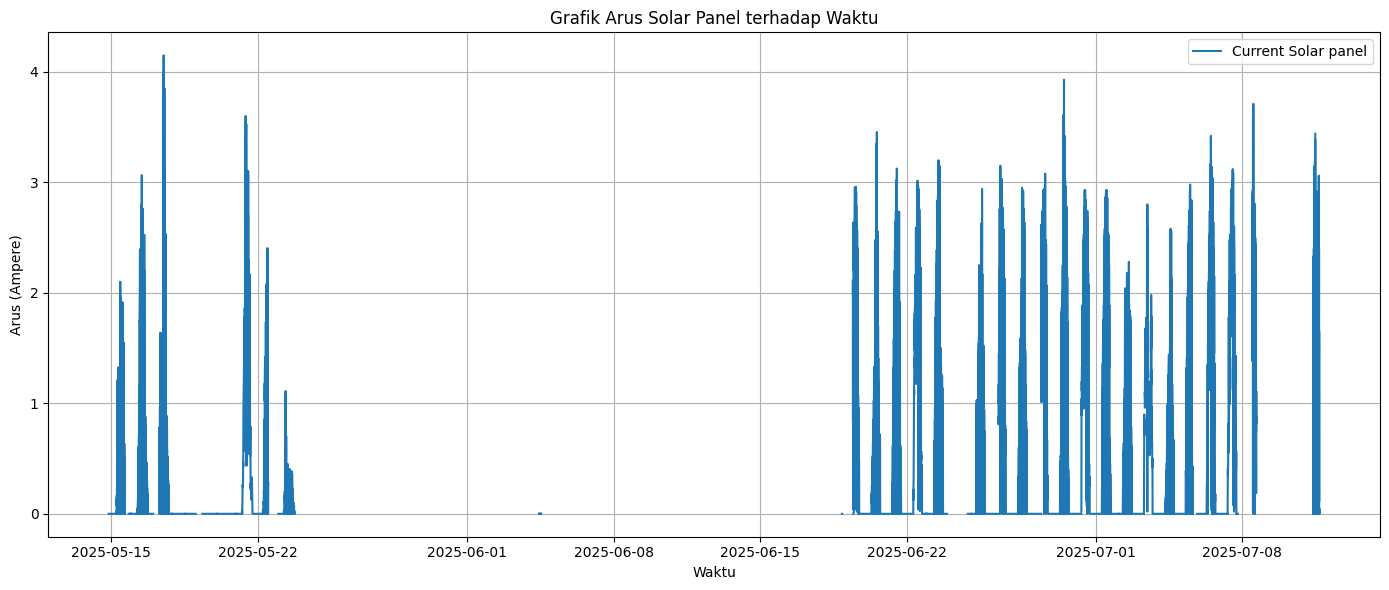

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca file CSV gabungan
df = pd.read_csv("data_gabungan_2menit.csv")

# Konversi kolom waktu ke format datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Pilih kolom yang berkaitan dengan tegangan dan arus dari solar panel
solar_panel_cols = [col for col in df.columns if (
    ('voltage' in col.lower() or 'current' in col.lower()) and 
    ('_pzem' in col.lower() or 'panel' in col.lower())
)]

# Pisahkan antara tegangan dan arus
voltage_cols = [col for col in solar_panel_cols if 'voltage' in col.lower()]
current_cols = [col for col in solar_panel_cols if 'current' in col.lower()]

# Grafik Tegangan Solar Panel
plt.figure(figsize=(14, 6))
for col in voltage_cols:
    plt.plot(df['created_at'], df[col], label=col)
plt.xlabel('Waktu')
plt.ylabel('Tegangan (Volt)')
plt.title('Grafik Tegangan Solar Panel terhadap Waktu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafik Arus Solar Panel
plt.figure(figsize=(14, 6))
for col in current_cols:
    plt.plot(df['created_at'], df[col], label=col)
plt.xlabel('Waktu')
plt.ylabel('Arus (Ampere)')
plt.title('Grafik Arus Solar Panel terhadap Waktu')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd

# 1. Baca file gabungan
df = pd.read_csv("data_gabungan_2menit.csv")

# 2. Konversi waktu dan set sebagai index
df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

# 3. Kolom penting untuk regresi
cols = ['Voltage solar panel', 'Current Solar panel', 'light intensity']

# 4. Filter baris valid (tidak NaN dan tidak 0)
valid_rows = df[cols].notna().all(axis=1) & (df[cols] != 0).all(axis=1)

# 5. Tambahkan kolom tanggal
df['date'] = df.index.date

# 6. Hitung jumlah data valid per tanggal
valid_counts = df[valid_rows].groupby('date')[cols].count()
valid_counts['total_valid'] = valid_counts.sum(axis=1)

# 7. Ambil tanggal terbaik
best_day = valid_counts['total_valid'].idxmax()

# 8. Ambil semua data pada tanggal tersebut
daily_data = df[df['date'] == best_day]

# 9. Ambil hanya baris valid
daily_data_valid = daily_data[
    daily_data[cols].notna().all(axis=1) & (daily_data[cols] != 0).all(axis=1)
]

# 10. (Opsional) Simpan ke CSV
daily_data_valid.to_csv(f"data_harian_{best_day}_untuk_regresi.csv", index=True)

# Tampilkan ringkasan
print(f"Tanggal terbaik: {best_day}")
print(f"Jumlah data valid: {len(daily_data_valid)}")


Tanggal terbaik: 2025-05-21
Jumlah data valid: 358


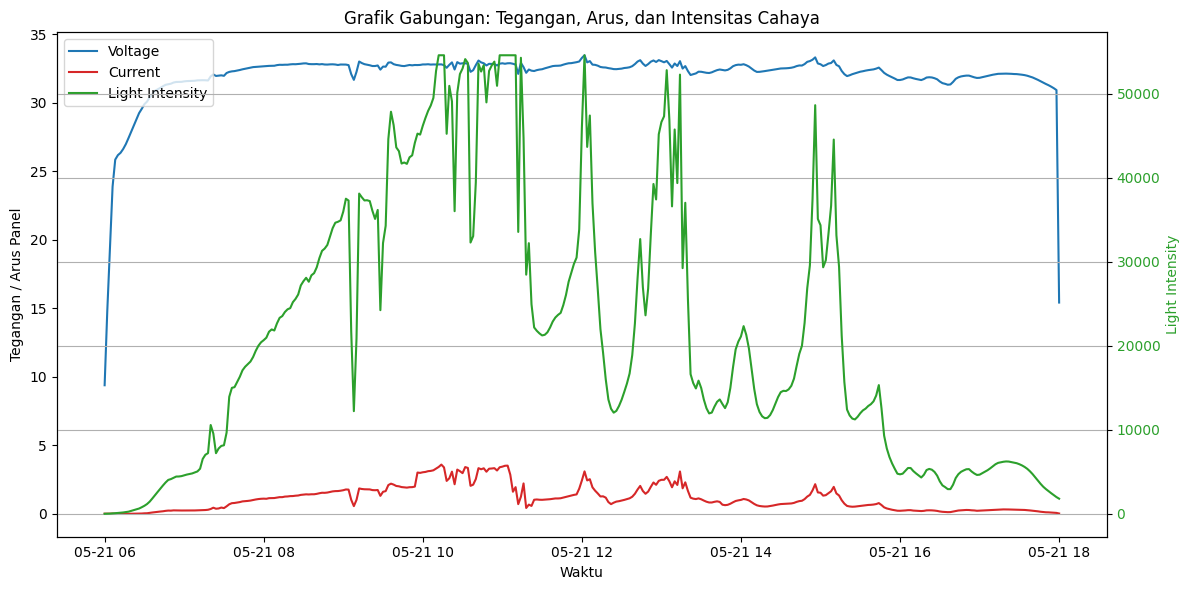

In [3]:
import matplotlib.pyplot as plt

# Misalnya data kamu sudah disiapkan dalam DataFrame: daily_data_valid
# dan kolom waktu sudah jadi index datetime

fig, ax1 = plt.subplots(figsize=(12, 6))

# Sumbu Y kiri: Tegangan dan Arus Solar Panel
ax1.plot(daily_data_valid.index, daily_data_valid['Voltage solar panel'], label='Voltage', color='tab:blue')
ax1.plot(daily_data_valid.index, daily_data_valid['Current Solar panel'], label='Current', color='tab:red')
ax1.set_xlabel("Waktu")
ax1.set_ylabel("Tegangan / Arus Panel", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Sumbu Y kanan: Light Intensity
ax2 = ax1.twinx()
ax2.plot(daily_data_valid.index, daily_data_valid['light intensity'], label='Light Intensity', color='tab:green')
ax2.set_ylabel("Light Intensity", color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Gabungkan legend dari kedua axis
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("Grafik Gabungan: Tegangan, Arus, dan Intensitas Cahaya")
plt.grid(True)
plt.tight_layout()
plt.show()


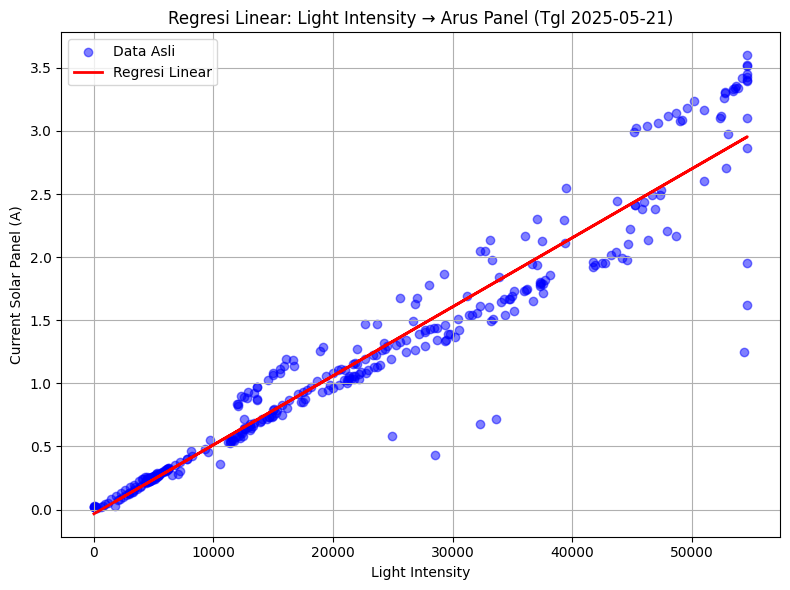

Hasil Model Regresi Linear
  - Tanggal Data:        2025-05-21
  - Koefisien (Slope):   0.00005473
  - Intercept:           -0.0344
  - R² Score:            0.924
  - RMSE:                0.254


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Baca data gabungan
df = pd.read_csv("data_gabungan_2menit.csv")
df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

# 2. Tentukan kolom penting dan buat kolom tanggal
cols = ['Voltage solar panel', 'Current Solar panel', 'light intensity']
df['date'] = df.index.date

# 3. Filter data valid (tidak NaN dan tidak 0)
valid_rows = df[cols].notna().all(axis=1) & (df[cols] != 0).all(axis=1)

# 4. Cari tanggal terbaik (jumlah data valid terbanyak)
valid_counts = df[valid_rows].groupby('date')[cols].count()
valid_counts['total_valid'] = valid_counts.sum(axis=1)
best_day = valid_counts['total_valid'].idxmax()

# 5. Ambil data valid dari tanggal terbaik
daily_data = df[df['date'] == best_day]
daily_valid = daily_data[daily_data[cols].notna().all(axis=1) & (daily_data[cols] != 0).all(axis=1)]

# 6. Siapkan variabel X dan y
X = daily_valid[['light intensity']].values
y = daily_valid['Current Solar panel'].values

# 7. Latih model regresi linear
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# 8. Evaluasi model
r2 = r2_score(y, y_pred)    
rmse = np.sqrt(mean_squared_error(y, y_pred))
slope = model.coef_[0]
intercept = model.intercept_

# 9. Tampilkan hasil regresi
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', alpha=0.5, label='Data Asli')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regresi Linear')
plt.xlabel("Light Intensity")
plt.ylabel("Current Solar Panel (A)")
plt.title(f"Regresi Linear: Light Intensity → Arus Panel (Tgl {best_day})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Cetak metrik model
print("Hasil Model Regresi Linear")
print(f"  - Tanggal Data:        {best_day}")
print(f"  - Koefisien (Slope):   {slope:.8f}")
print(f"  - Intercept:           {intercept:.4f}")
print(f"  - R² Score:            {r2:.3f}")
print(f"  - RMSE:                {rmse:.3f}")


In [ ]:
import pandas as pd

# 1. Baca file gabungan
df = pd.read_csv("data_gabungan_2menit.csv")
df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

# 2. Tambahkan kolom tanggal
df['date'] = df.index.date

# 3. Tentukan kolom penting
cols = ['Voltage solar panel', 'Current Solar panel', 'light intensity']

# 4. Tandai baris valid (bukan NaN)
valid_rows = df[cols].notna().all(axis=1)

# 5. Hitung jumlah data valid per hari
valid_counts = df[valid_rows].groupby('date')[cols].count()
valid_counts['total_valid'] = valid_counts.sum(axis=1)

# 6. Ambil hari dengan total ≥ 400 per kolom (artinya ≥ 1200 total)
eligible_days = valid_counts[valid_counts['total_valid'] >= 3 * 400].copy()

# 7. Tambahkan nama hari
eligible_days.index = pd.to_datetime(eligible_days.index)
eligible_days['Hari'] = eligible_days.index.day_name()
eligible_days.reset_index(inplace=True)
eligible_days.rename(columns={'date': 'Tanggal'}, inplace=True)

# 8. Tampilkan hasil
print("Hari & Tanggal Layak Regresi (≥ 400 data per parameter):")
print(eligible_days[['Tanggal', 'Hari', 'Voltage solar panel', 'Current Solar panel', 'light intensity']])


Hari & Tanggal Layak Regresi (≥ 400 data per parameter):
      Tanggal       Hari  Voltage solar panel  Current Solar panel  \
0  2025-05-15   Thursday                  559                  559   
1  2025-05-16     Friday                  672                  672   
2  2025-05-17   Saturday                  442                  442   
3  2025-05-18     Sunday                  647                  647   
4  2025-05-19     Monday                  494                  494   
5  2025-05-20    Tuesday                  694                  694   
6  2025-05-21  Wednesday                  717                  717   
7  2025-06-20     Friday                  500                  500   
8  2025-06-21   Saturday                  405                  405   
9  2025-06-23     Monday                  646                  646   
10 2025-06-25  Wednesday                  709                  709   
11 2025-06-26   Thursday                  708                  708   
12 2025-06-27     Friday         

<Figure size 1200x600 with 0 Axes>

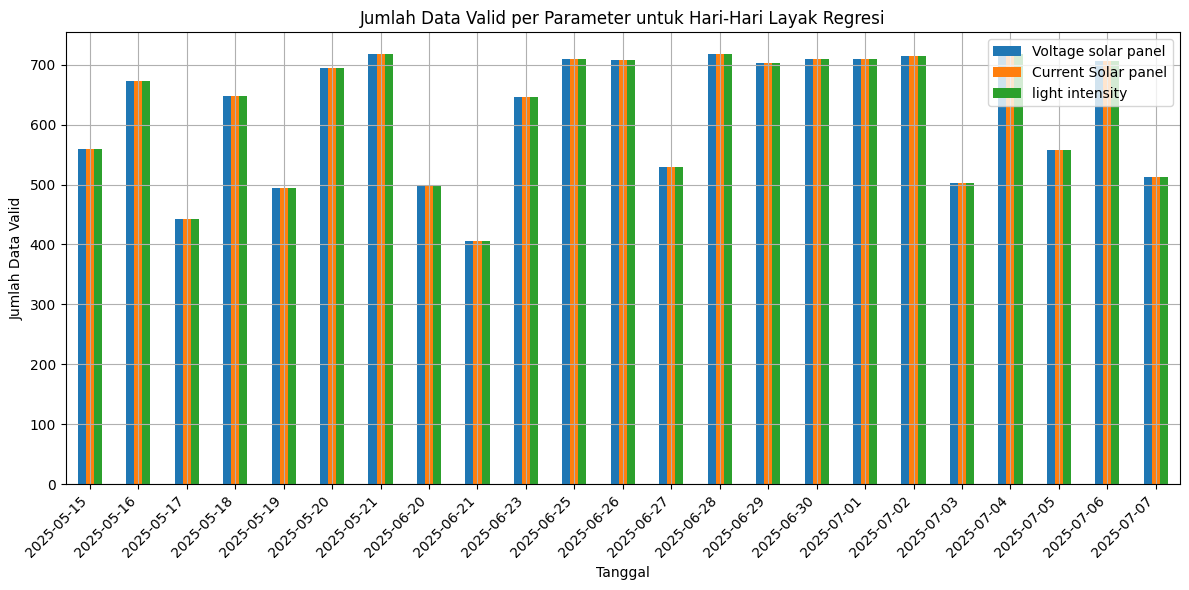

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baca data gabungan
df = pd.read_csv("data_gabungan_2menit.csv")
df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

# 2. Tambah kolom tanggal
df['date'] = df.index.date

# 3. Tentukan parameter penting
cols = ['Voltage solar panel', 'Current Solar panel', 'light intensity']

# 4. Tandai baris valid (tidak NaN)
valid_rows = df[cols].notna().all(axis=1)

# 5. Hitung jumlah data valid per hari
valid_counts = df[valid_rows].groupby('date')[cols].count()
valid_counts['total_valid'] = valid_counts.sum(axis=1)

# 6. Pilih hari dengan total valid ≥ 3 * 400
eligible_days = valid_counts[valid_counts['total_valid'] >= 3 * 400].copy()

# 7. Plot jumlah data valid per parameter per hari
plt.figure(figsize=(12, 6))
eligible_days[['Voltage solar panel', 'Current Solar panel', 'light intensity']].plot(
    kind='bar',
    stacked=False,
    figsize=(12, 6)
)
plt.title("Jumlah Data Valid per Parameter untuk Hari-Hari Layak Regresi")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Data Valid")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Baca data gabungan
df = pd.read_csv("data_gabungan_2menit.csv")
df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)
df['date'] = df.index.date

# 2. Tentukan parameter penting
cols = ['Voltage solar panel', 'Current Solar panel', 'light intensity']

# 3. Identifikasi hari layak regresi (≥400 data valid per parameter)
valid_rows = df[cols].notna().all(axis=1)
valid_counts = df[valid_rows].groupby('date')[cols].count()
valid_counts['total_valid'] = valid_counts.sum(axis=1)
eligible_days = valid_counts[valid_counts['total_valid'] >= 3 * 400].copy()
eligible_days.reset_index(inplace=True)
eligible_days.rename(columns={'date': 'Tanggal'}, inplace=True)

# 4. Latih model regresi dari tanggal 21 Mei 2025
tanggal_model = pd.to_datetime("2025-05-21").date()
train_data = df[df['date'] == tanggal_model]
mask_train = train_data[['light intensity', 'Current Solar panel']].notna().all(axis=1)
mask_train &= train_data['light intensity'] != 0
mask_train &= train_data['Current Solar panel'] != 0
train_data = train_data[mask_train]

X_train = train_data[['light intensity']].values
y_train = train_data['Current Solar panel'].values
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Terapkan model ke tanggal-tanggal lain yang layak (kecuali 21 Mei)
tanggal_target = eligible_days['Tanggal']
tanggal_target = tanggal_target[tanggal_target != tanggal_model]

filled_df = df.copy()

for tanggal in tanggal_target:
    mask_day = filled_df['date'] == tanggal
    df_day = filled_df[mask_day]

    mask_impute = (
        (df_day['Power Solar Panel'] == 0) &
        (df_day['Voltage solar panel'].notna()) &
        (df_day['light intensity'].notna()) &
        (df_day['light intensity'] > 0)
    )

    X_pred = df_day.loc[mask_impute, ['light intensity']]
    predicted_current = model.predict(X_pred)
    predicted_power = df_day.loc[mask_impute, 'Voltage solar panel'].values * predicted_current

    # Update nilai arus dan daya
    filled_df.loc[mask_day & mask_impute, 'Current Solar panel'] = predicted_current
    filled_df.loc[mask_day & mask_impute, 'Power Solar Panel'] = predicted_power

# 6. Simpan hasil
filled_df.to_csv("data_gabungan_2menit_filled.csv")


c:\Users\marsh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\marsh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\marsh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\marsh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\marsh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearR

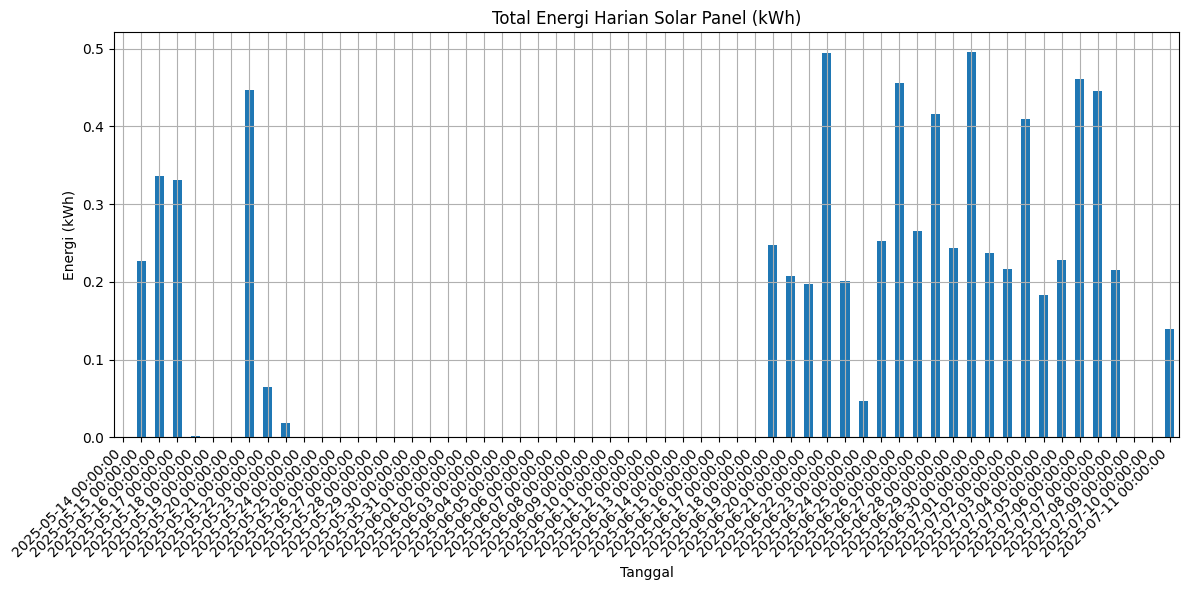

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baca data hasil imputasi
df = pd.read_csv("data_gabungan_2menit_filled.csv")
df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

# 2. Hitung energi per titik (2 menit) → kWh
df['Energy_kWh'] = df['Power Solar Panel'] * (2 / 60) / 1000  # Power in W, waktu 2 menit

# 3. Agregasi total energi per hari
daily_energy = df.groupby(df.index.date)['Energy_kWh'].sum()
daily_energy.index = pd.to_datetime(daily_energy.index)

# 4. Plot grafik energi harian
plt.figure(figsize=(12, 6))
daily_energy.plot(kind='bar')
plt.title("Total Energi Harian Solar Panel (kWh)")
plt.xlabel("Tanggal")
plt.ylabel("Energi (kWh)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1400x600 with 0 Axes>

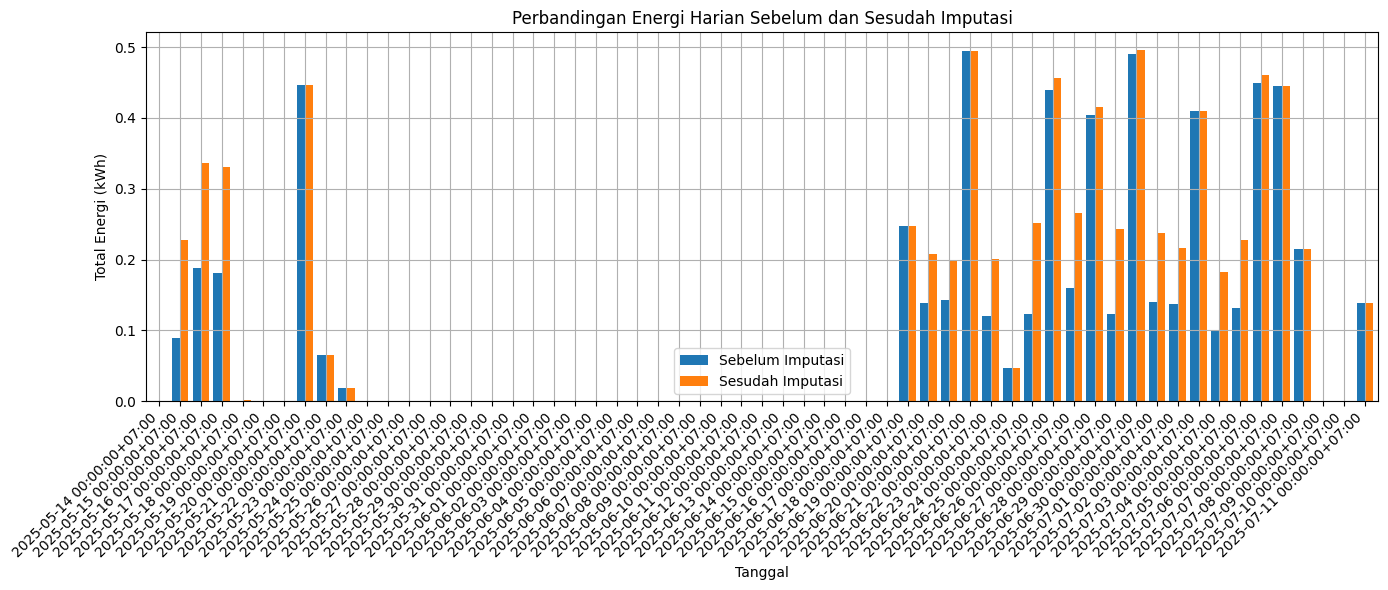

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baca file sebelum dan sesudah imputasi
df_asli = pd.read_csv("data_gabungan_2menit.csv")
df_isi = pd.read_csv("data_gabungan_2menit_filled.csv")

# 2. Parsing datetime dan index
df_asli['created_at'] = pd.to_datetime(df_asli['created_at'])
df_isi['created_at'] = pd.to_datetime(df_isi['created_at'])
df_asli.set_index('created_at', inplace=True)
df_isi.set_index('created_at', inplace=True)

# 3. Hitung energi kWh per titik (2 menit)
df_asli['Energy_kWh'] = df_asli['Power Solar Panel'] * (2 / 60) / 1000
df_isi['Energy_kWh'] = df_isi['Power Solar Panel'] * (2 / 60) / 1000

# 4. Hitung energi harian
energi_harian_asli = df_asli['Energy_kWh'].resample('D').sum()
energi_harian_isi = df_isi['Energy_kWh'].resample('D').sum()

# 5. Gabungkan dalam satu DataFrame
perbandingan = pd.DataFrame({
    'Sebelum Imputasi': energi_harian_asli,
    'Sesudah Imputasi': energi_harian_isi
}).fillna(0)

# 6. Buat grafik bar
plt.figure(figsize=(14, 6))
perbandingan.plot(kind='bar', width=0.8, figsize=(14, 6))
plt.title("Perbandingan Energi Harian Sebelum dan Sesudah Imputasi")
plt.xlabel("Tanggal")
plt.ylabel("Total Energi (kWh)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


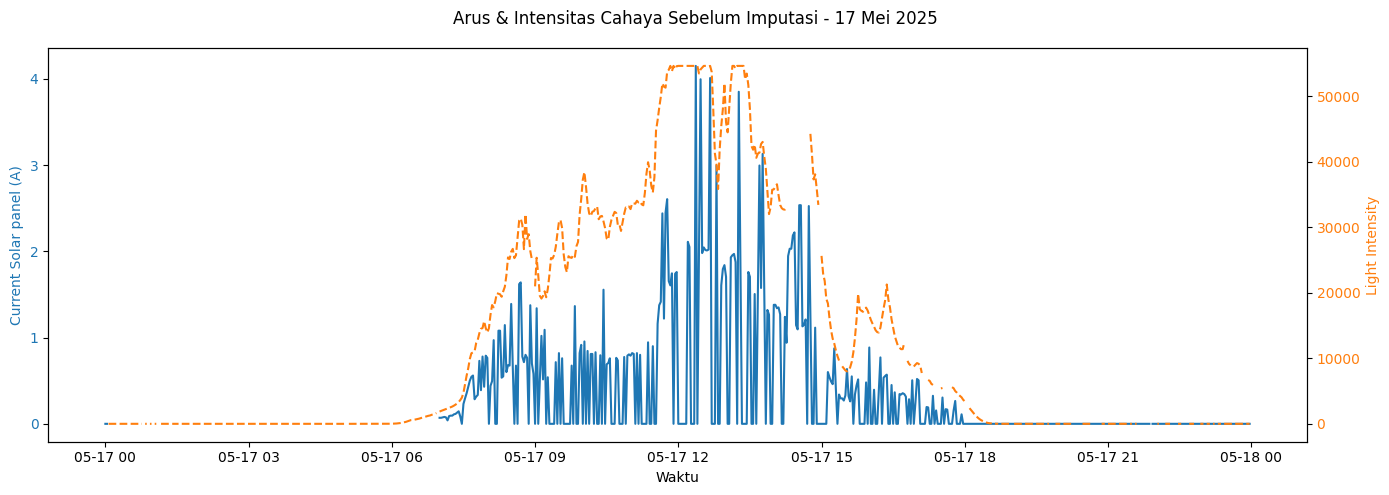

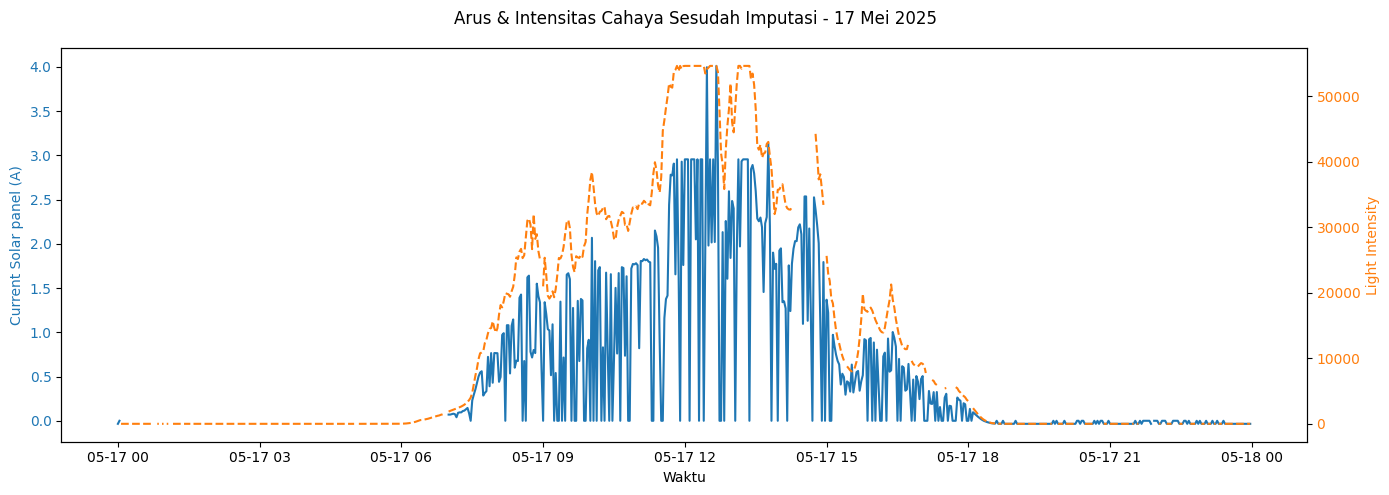

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Baca file CSV dan parsing datetime
df_asli = pd.read_csv("data_gabungan_2menit.csv", parse_dates=['created_at'])
df_isi = pd.read_csv("data_gabungan_2menit_filled.csv", parse_dates=['created_at'])

# 2. Set datetime sebagai index
df_asli.set_index('created_at', inplace=True)
df_isi.set_index('created_at', inplace=True)

# 3. Filter data untuk tanggal 17 Mei 2025 (dengan mask tanggal)
tanggal = "2025-05-17"
data_asli = df_asli[df_asli.index.date == pd.to_datetime(tanggal).date()]
data_isi = df_isi[df_isi.index.date == pd.to_datetime(tanggal).date()]

# ---------- Grafik SEBELUM Imputasi ----------
fig, ax1 = plt.subplots(figsize=(14, 5))

color = 'tab:blue'
ax1.set_xlabel('Waktu')
ax1.set_ylabel('Current Solar panel (A)', color=color)
ax1.plot(data_asli.index, data_asli['Current Solar panel'], color=color, label='Arus (Sebelum)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Light Intensity', color=color)
ax2.plot(data_asli.index, data_asli['light intensity'], color=color, linestyle='--', label='Intensitas Cahaya')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Arus & Intensitas Cahaya Sebelum Imputasi - 17 Mei 2025')
fig.tight_layout()
plt.show()

# ---------- Grafik SESUDAH Imputasi ----------
fig, ax1 = plt.subplots(figsize=(14, 5))

color = 'tab:blue'
ax1.set_xlabel('Waktu')
ax1.set_ylabel('Current Solar panel (A)', color=color)
ax1.plot(data_isi.index, data_isi['Current Solar panel'], color=color, label='Arus (Sesudah)')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Light Intensity', color=color)
ax2.plot(data_isi.index, data_isi['light intensity'], color=color, linestyle='--', label='Intensitas Cahaya')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Arus & Intensitas Cahaya Sesudah Imputasi - 17 Mei 2025')
fig.tight_layout()
plt.show()


In [20]:
import pandas as pd

# 1. Baca file data gabungan hasil imputasi
df_filled = pd.read_csv("data_gabungan_2menit_filled.csv")
df_filled['created_at'] = pd.to_datetime(df_filled['created_at'])
df_filled.set_index('created_at', inplace=True)

# 2. Tambahkan kolom tanggal
df_filled['date'] = df_filled.index.date

# 3. Tentukan kolom yang relevan
cols = ['Voltage solar panel', 'Current Solar panel', 'light intensity']

# 4. Tandai baris valid (hanya bukan NaN, tetapi nilai 0 tetap dianggap valid)
valid_rows = df_filled[cols].notna().all(axis=1)  # hanya menghindari NaN, nilai 0 tetap valid

# 5. Hitung jumlah data valid per hari
valid_counts = df_filled[valid_rows].groupby('date')[cols].count()
valid_counts['total_valid'] = valid_counts.sum(axis=1)

# 6. Pilih hari dengan total valid ≥ 3 * 400 (artinya ≥ 1200 total)
eligible_days = valid_counts[valid_counts['total_valid'] >= 3 * 400].copy()

# 7. Tambahkan nama hari
eligible_days.index = pd.to_datetime(eligible_days.index)
eligible_days['Hari'] = eligible_days.index.day_name()
eligible_days.reset_index(inplace=True)
eligible_days.rename(columns={'date': 'Tanggal'}, inplace=True)

# 8. Tampilkan hasil
print("Hari dan Tanggal Layak untuk Model LSTM:")
print(eligible_days[['Tanggal', 'Hari', 'Voltage solar panel', 'Current Solar panel', 'light intensity']])

Hari dan Tanggal Layak untuk Model LSTM:
      Tanggal       Hari  Voltage solar panel  Current Solar panel  \
0  2025-05-15   Thursday                  559                  559   
1  2025-05-16     Friday                  672                  672   
2  2025-05-17   Saturday                  442                  442   
3  2025-05-18     Sunday                  647                  647   
4  2025-05-19     Monday                  494                  494   
5  2025-05-20    Tuesday                  694                  694   
6  2025-05-21  Wednesday                  717                  717   
7  2025-06-20     Friday                  500                  500   
8  2025-06-21   Saturday                  405                  405   
9  2025-06-23     Monday                  646                  646   
10 2025-06-25  Wednesday                  709                  709   
11 2025-06-26   Thursday                  708                  708   
12 2025-06-27     Friday                  530    

In [21]:
import pandas as pd

# 1. Baca file data gabungan hasil imputasi
df_filled = pd.read_csv("data_gabungan_2menit_filled.csv")
df_filled['created_at'] = pd.to_datetime(df_filled['created_at'])
df_filled.set_index('created_at', inplace=True)

# 2. Tambahkan kolom tanggal
df_filled['date'] = df_filled.index.date

# 3. Tentukan kolom yang relevan
cols = ['Voltage solar panel', 'Current Solar panel', 'light intensity']

# 4. Tandai baris valid (bukan NaN dan tidak 0, tetapi 0 dianggap valid)
valid_rows = df_filled[cols].notna().all(axis=1)  # hanya menghindari NaN, nilai 0 tetap valid

# 5. Hitung jumlah data valid per hari
valid_counts = df_filled[valid_rows].groupby('date')[cols].count()
valid_counts['total_valid'] = valid_counts.sum(axis=1)

# 6. Pilih hari dengan total valid ≥ 3 * 400 (artinya ≥ 1200 total valid)
eligible_days = valid_counts[valid_counts['total_valid'] >= 3 * 400].copy()

# 7. Filter data berdasarkan tanggal yang memenuhi kriteria valid
valid_dates = eligible_days.index
df_valid = df_filled[df_filled['date'].isin(valid_dates)]

# 8. Simpan data valid ke file baru
output_file_path = "data_valid_for_LSTM.csv"
df_valid.to_csv(output_file_path)

# 9. Tampilkan lokasi file hasil
print(f"File baru data valid untuk LSTM disimpan di: {output_file_path}")

File baru data valid untuk LSTM disimpan di: data_valid_for_LSTM.csv


In [37]:
import pandas as pd

# Pastikan data telah dimuat
data = pd.read_csv("data_valid_for_LSTM.csv") # Jika data belum dimuat

# Daftar kolom yang akan diperiksa
columns_to_check = [
    'temperature', 
    'Humidity', 
    'irradiance', 
    'light intensity', 
    'Voltage solar panel', 
    'Current Solar panel'
]

# Mencari data yang mengandung nilai negatif pada kolom-kolom tersebut
negative_data = data[(data[columns_to_check] < 0).any(axis=1)]

# Menampilkan head dari data yang mengandung nilai minus
negative_head = negative_data[columns_to_check].head()

# Menemukan parameter yang memiliki nilai minus
negative_columns = [col for col in columns_to_check if (data[col] < 0).any()]

# Menampilkan hasil
print("Head of data with negative values:")
print(negative_head)
print("\nParameters with negative values:")
print(negative_columns)


Head of data with negative values:
   temperature  Humidity  irradiance  light intensity  Voltage solar panel  \
0        22.65      65.6   -0.000350          1.66667                  0.0   
1        22.60      65.8   -0.001055          1.66667                  0.0   
2        22.60      65.5   -0.000350          1.66667                  0.0   
3        22.60      65.7   -0.001760          1.66667                  0.0   
4        22.60      65.5   -0.001050          1.66667                  0.0   

   Current Solar panel  
0            -0.034352  
1            -0.034352  
2            -0.034352  
3            -0.034352  
4            -0.034352  

Parameters with negative values:
['irradiance', 'light intensity', 'Current Solar panel']


In [44]:
import pandas as pd

# Pastikan data telah dimuat
data = pd.read_csv("data_valid_for_LSTM.csv")

# Daftar kolom yang mengandung nilai negatif yang akan diganti
columns_to_fix = ['irradiance', 'light intensity', 'Current Solar panel']

# Mengganti nilai negatif pada kolom yang relevan dengan nilai kecil (0.001)
for col in columns_to_fix:
    data[col] = data[col].apply(lambda x: 0.001 if x < 0 else x)

# Menampilkan head dari data yang telah diperbaiki
print("Data setelah mengganti nilai negatif dengan nilai kecil (0.001):")
print(data[columns_to_fix].head())

# Mengonversi kolom 'created_at' menjadi datetime
data['created_at'] = pd.to_datetime(data['created_at'])

# Mengabaikan data dengan nilai 0 pada 'Voltage solar panel' atau 'Current Solar panel' selama jam 7 pagi - 5 sore
filtered_data = data[~((data['Voltage solar panel'] == 0) | (data['Current Solar panel'] == 0)) | 
                     ((data['created_at'].dt.hour < 7) | (data['created_at'].dt.hour >= 17))]

# Menampilkan head dari data yang telah difilter
filtered_data[['created_at', 'Voltage solar panel', 'Current Solar panel']].head()

# Menghapus baris dengan nilai NaN pada kolom 'Voltage solar panel' dan 'Current Solar panel'
filtered_data_cleaned = filtered_data.dropna(subset=['Voltage solar panel', 'Current Solar panel'])

# Menampilkan head dari data yang telah dibersihkan
print("Data setelah menghapus baris dengan NaN pada 'Voltage solar panel' dan 'Current Solar panel':")
print(filtered_data_cleaned[['created_at', 'Voltage solar panel', 'Current Solar panel']].head())

# Menyimpan data yang telah dibersihkan ke file baru
filtered_data_cleaned.to_csv("data_cleaned_for_LSTM.csv", index=False)


Data setelah mengganti nilai negatif dengan nilai kecil (0.001):
   irradiance  light intensity  Current Solar panel
0       0.001          1.66667                0.001
1       0.001          1.66667                0.001
2       0.001          1.66667                0.001
3       0.001          1.66667                0.001
4       0.001          1.66667                0.001
Data setelah menghapus baris dengan NaN pada 'Voltage solar panel' dan 'Current Solar panel':
                 created_at  Voltage solar panel  Current Solar panel
0 2025-05-15 00:00:00+07:00                  0.0                0.001
1 2025-05-15 00:02:00+07:00                  0.0                0.001
2 2025-05-15 00:04:00+07:00                  0.0                0.001
3 2025-05-15 00:06:00+07:00                  0.0                0.001
4 2025-05-15 00:08:00+07:00                  0.0                0.001


Data mengandung NaN atau Infinity sebelum penanganan.
Masih terdapat NaN atau Infinity setelah penggantian.
Epoch 1/50


C:\Users\marsh\AppData\Local\Temp\ipykernel_33852\2151697749.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_1['power'] = data_model_1['Voltage solar panel'] * data_model_1['Current Solar panel']


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 0.0077
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8716e-04 - val_loss: 0.0015
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0510e-04 - val_loss: 0.0014
Epoch 9/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.9168e-04 - val_loss: 0.0010
Epoch 10/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0842e-04 - val_loss: 0.0011
Epoch 11/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5093e-04 - val_loss: 0.0012
Epoch 12/50
102/102 ━━━━━━━━━━━━━━━

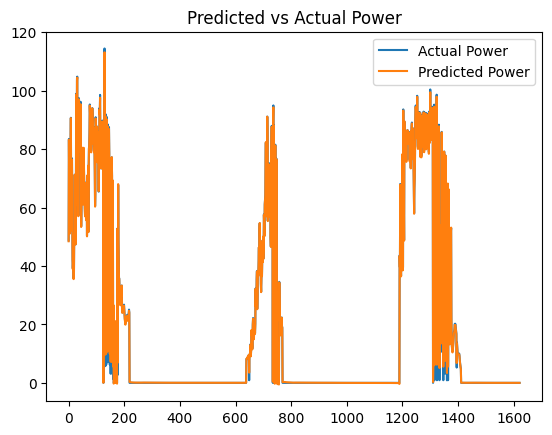

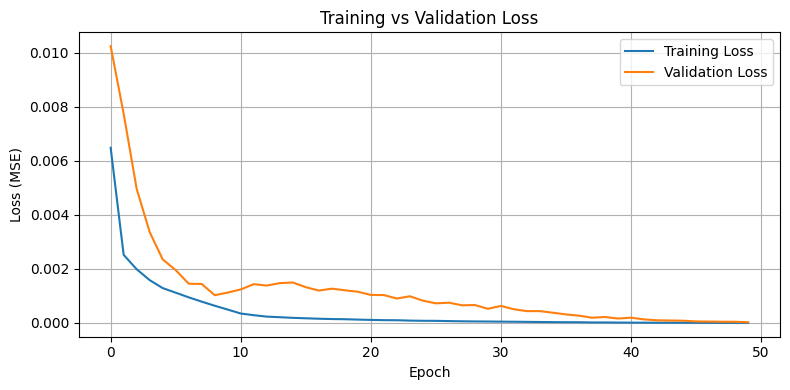

Mean Squared Error (MSE) untuk Model LSTM: 0.44244517454272025


In [ ]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Langkah 1: Memuat data yang telah dibersihkan
file_path = 'data_valid_for_LSTM.csv'
data = pd.read_csv(file_path)

# Langkah 2: Menangani NaN dan Infinity pada data   
# Memilih hanya kolom numerik
numeric_columns = data.select_dtypes(include=[np.number])

# Memeriksa apakah ada NaN atau Infinity dalam kolom numerik
if np.any(np.isnan(numeric_columns)) or np.any(np.isinf(numeric_columns)):
    print("Data mengandung NaN atau Infinity sebelum penanganan.")
    
    # Mengganti NaN dan Infinity dengan nilai kecil (misalnya, 0.001)
    data[numeric_columns.columns] = numeric_columns.apply(lambda x: np.nan_to_num(x, nan=0.001, posinf=0.001, neginf=0.001))
    
    # Memeriksa lagi setelah penggantian
    if np.any(np.isnan(numeric_columns)) or np.any(np.isinf(numeric_columns)):
        print("Masih terdapat NaN atau Infinity setelah penggantian.")
    else:
        print("NaN dan Infinity berhasil ditangani.")
else:
    print("Data tidak mengandung NaN atau Infinity.")

# Langkah 3: Mengonversi kolom 'created_at' menjadi datetime
data['created_at'] = pd.to_datetime(data['created_at'])

# Langkah 4: Mengabaikan data dengan nilai 0 pada 'Voltage solar panel' atau 'Current Solar panel' selama jam 7 pagi - 5 sore
data['hour'] = data['created_at'].dt.hour
filtered_data = data[~((data['Voltage solar panel'] == 0) | (data['Current Solar panel'] == 0)) | 
                     ((data['hour'] < 7) | (data['hour'] >= 17))]

# Langkah 5: Memfilter data berdasarkan rentang tanggal (2025-05-15 hingga 2025-06-29)
start_date = '2025-05-15'
end_date = '2025-06-29'
data_model_1 = filtered_data[(filtered_data['created_at'] >= start_date) & (filtered_data['created_at'] <= end_date)]

# Langkah 6: Menangani nilai negatif untuk kolom tertentu
columns_to_fix = ['irradiance', 'light intensity', 'Current Solar panel']
for col in columns_to_fix:
    # Menggunakan loc[] untuk menghindari SettingWithCopyWarning
    data_model_1.loc[:, col] = data_model_1[col].apply(lambda x: 0.001 if x < 0 else x)

# Langkah 7: Persiapan Data
features = ['temperature', 'Humidity', 'irradiance', 'light intensity', 'Voltage solar panel', 'Current Solar panel']
data_model_1['power'] = data_model_1['Voltage solar panel'] * data_model_1['Current Solar panel']
target = 'power'

X = data_model_1[features].values
y = data_model_1[target].values

# Langkah 8: Normalisasi data menggunakan MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Langkah 9: Membagi data menjadi training dan testing (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Langkah 10: Mengubah data untuk LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, timesteps, features)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Langkah 11: Menyesuaikan Epochs, Batch Size, Learning Rate, dan Unit LSTM
epochs = 50  # Meningkatkan jumlah epochs
batch_size = 64  # Meningkatkan batch size
learning_rate = 0.001  # Menurunkan learning rate

# Menggunakan optimizer dengan learning rate lebih rendah
optimizer = Adam(learning_rate=learning_rate)

# Membangun model LSTM dengan lebih banyak unit LSTM
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer
model.add(LSTM(units=100, return_sequences=False))  # Meningkatkan jumlah unit LSTM
model.add(Dense(units=1))  # Output layer untuk prediksi power

# Langkah 12: Compile dan latih model
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Langkah 13: Evaluasi model dengan data uji
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# Menampilkan grafik perbandingan antara nilai aktual dan prediksi
plt.plot(scaler_y.inverse_transform(y_test), label='Actual Power')
plt.plot(y_pred_rescaled, label='Predicted Power')
plt.legend()
plt.title('Predicted vs Actual Power')
plt.show()

# Langkah Tambahan 1: Grafik Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Metrik evaluasi dengan Mean Squared Error (MSE)
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred_rescaled)
print(f'Mean Squared Error (MSE) untuk Model LSTM: {mse}')

In [58]:
model.save("model_lstm_power_1.h5")
print("✅ Model berhasil disimpan.")

from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

y_actual = scaler_y.inverse_transform(y_test)
y_predicted = y_pred_rescaled

mae = mean_absolute_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_predicted)

print(f"📊 Evaluasi Tambahan:")
print(f"🔹 Mean Absolute Error (MAE): {mae}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse}")
print(f"🔹 R² Score: {r2}")


✅ Model berhasil disimpan.
📊 Evaluasi Tambahan:
🔹 Mean Absolute Error (MAE): 0.22518777569540033
🔹 Root Mean Squared Error (RMSE): 0.6651655241687743
🔹 R² Score: 0.9995413958168046


c:\Users\marsh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


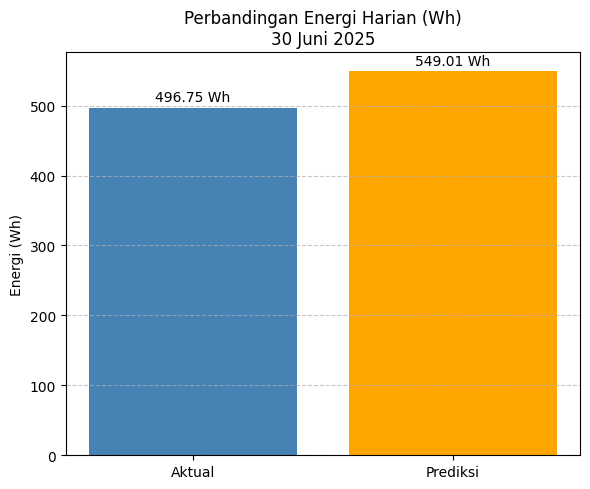

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load model
model = load_model('model_lstm_power_1.h5')

# Load dan olah data
file_path = 'data_valid_for_LSTM.csv'
data = pd.read_csv(file_path)
data['created_at'] = pd.to_datetime(data['created_at'])

# Filter data tanggal 30 Juni 2025
data_30_juni = data[data['created_at'].dt.date == pd.to_datetime('2025-06-30').date()].copy()

# Tangani nilai negatif
columns_to_fix = ['irradiance', 'light intensity', 'Current Solar panel']
for col in columns_to_fix:
    data_30_juni.loc[:, col] = data_30_juni[col].apply(lambda x: 0.001 if x < 0 else x)

# Tangani nilai nol saat siang hari
data_30_juni.loc[:, 'hour'] = data_30_juni['created_at'].dt.hour
data_30_juni = data_30_juni[~(((data_30_juni['Voltage solar panel'] == 0) | 
                               (data_30_juni['Current Solar panel'] == 0)) & 
                              ((data_30_juni['hour'] >= 7) & (data_30_juni['hour'] < 17)))]

# Hitung power
data_30_juni['power'] = data_30_juni['Voltage solar panel'] * data_30_juni['Current Solar panel']

# Cek jika tidak ada data
if data_30_juni.empty:
    raise ValueError("Data tanggal 30 Juni 2025 kosong setelah penyaringan. Silakan periksa sumber data.")

# Fitur dan target
features = ['temperature', 'Humidity', 'irradiance', 'light intensity', 'Voltage solar panel', 'Current Solar panel']
X_30 = data_30_juni[features].values
y_30 = data_30_juni['power'].values

# Buat dan fit scaler dari data yang telah digunakan untuk training
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_X.fit(data[features])
scaler_y.fit((data['Voltage solar panel'] * data['Current Solar panel']).values.reshape(-1, 1))

# Transformasi data
X_30_scaled = scaler_X.transform(X_30)
X_30_scaled = X_30_scaled.reshape((X_30_scaled.shape[0], 1, X_30_scaled.shape[1]))

# Prediksi
y_pred_scaled = model.predict(X_30_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Hitung energi Wh dengan interval 2 menit = 1/30 jam
data_30_juni['Predicted Power'] = y_pred
data_30_juni['Actual Energy_Wh'] = data_30_juni['power'] * (1/30)
data_30_juni['Predicted Energy_Wh'] = data_30_juni['Predicted Power'] * (1/30)

# Total energi
total_actual_energy_wh = data_30_juni['Actual Energy_Wh'].sum()
total_predicted_energy_wh = data_30_juni['Predicted Energy_Wh'].sum()

# Plot perbandingan bar
labels = ['Aktual', 'Prediksi']
energi_wh = [total_actual_energy_wh, total_predicted_energy_wh]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, energi_wh, color=['steelblue', 'orange'])
plt.title('Perbandingan Energi Harian (Wh)\n30 Juni 2025')
plt.ylabel('Energi (Wh)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{height:.2f} Wh', ha='center', va='bottom')

plt.tight_layout()
plt.show()
